## Mean field approximation example

## Problem formalization

We want to perform image denoising on binary images. Let's formalize the problem. We have an observed image $\pmb{Y}$ where each observed pixel $Y_i \in [-1, +1]$ and original clean binary image is $\pmb{X}$.

Let's see joint distribution:

$$
P(\pmb{X}, \pmb{Y}) = P(\pmb{Y}|\pmb{X})P(\pmb{X})
$$

Where $P(\pmb{X})$ is the prior of the original image and $P(\pmb{Y}|\pmb{X})$ is the likelihood of the observed corrupted image given original.

Note that we will be abusing notation and use $Z$ for all constants.

### Prior

We want to enforce that neighboring pixels in the clean image have the same value. Thus, we define the prior as:

$$
\begin{align*}
P(\pmb{X}) & = \frac{1}{Z} \exp\left[ \sum_i \sum_{j \in neigh(i)} W_{ij} X_i X_j \right] \\
           & = \frac{1}{Z} \exp\left[ \sum_i X_i \sum_{j \in neigh(i)} W_{ij} X_j \right]
\end{align*}
$$

Where $W_{ij}$ is the coupling strength between neighbouring pixels and $neigh(i)$ is a function that retrieves the neighboring pixels of $X_i$.

For a single pixel $X_i$, we have:

$$
P(X_i) = \frac{1}{Z} \exp\left[ X_i \sum_{j \in neigh(i)} W_{ij} X_j \right] \\
$$

### Likelihood

We also want to enforece similarity between the clean and the observed image (which should only differ in the added perturbations). Therefore, we define likelihood:

$$
P(\pmb{Y} | \pmb{X}) = \prod_i P(Y_i | X_i) = \prod_i \mathcal{N}(Y_i|X_i, \sigma^2)
$$

Therefore, we assume the perturbations in the image are Gaussian, centered at the original value and with variance $\sigma^2$.

### Optimal value for q

In the [previous notebook](0_Variational_Inference_Mean_Field.ipynb), we saw that:

$$
\begin{align*}
q_k & = \hat{P}(\pmb{X}, \pmb{Y}) \\
    & = \frac{1}{Z} \exp \left[ \mathbb{E}_{q_{i \neq k}} \log P(\pmb{Y}, \pmb{X}) \right]  \\
\end{align*}
$$

If we replace the joint distribution in this example, we get:

$$
\begin{align*}
\log P(\pmb{Y}, \pmb{X}) & = \log P(\pmb{Y} | \pmb{X}) P(\pmb{X}) \\
                         & = \log \left\{ \prod_i \mathcal{N}(Y_i|X_i, \sigma^2) \frac{1}{Z_0} \exp\left[ \sum_i X_i \sum_{j \in neigh(i)} W_{ij} X_j \right] \right\} \\
                         & = \sum_i \log \mathcal{N}(Y_i|X_i, \sigma^2) + const + \sum_i X_i \sum_{j \in neigh(i)} W_{ij} X_j 
\end{align*}
$$

Note that, for a single pixel $i$, we have:

$$
\begin{align*}
\log P(Y_i, X_i) & = \log \mathcal{N}(Y_i|X_i, \sigma^2) + X_i \sum_{j \in neigh(i)} W_{ij} X_j + const
\end{align*}
$$


If we want to compute the optimal value for $q_k(X_k)$ (note we are not using abbreviation now), we can write:

$$
\begin{align*}
q_k(X_k) & = \frac{1}{Z} \exp \left[ \mathbb{E}_{q_{i \neq k}} \log P(Y_k, X_k) \right]  \\
         & = \frac{1}{Z} \exp \left\{ \mathbb{E}_{q_{i \neq k}} \left[ \log \mathcal{N}(Y_k|X_k, \sigma^2) + X_k \sum_{j \in neigh(k)} W_{kj} X_j + const \right] \right\} \\
         & = \frac{1}{Z} \exp \left[ \log \mathcal{N}(Y_k|X_k, \sigma^2) + X_k \sum_{j \in neigh(k)} W_{kj} \mathbb{E}_{q_{j}} \left[ X_j \right] \right] \\
         & = \frac{1}{Z} \exp \left[ \log \mathcal{N}(Y_k|X_k, \sigma^2) + X_k \sum_{j \in neigh(k)} W_{kj} \mu_j \right] \\
         & \propto \exp \left[ \log \mathcal{N}(Y_k|X_k, \sigma^2) + X_k \sum_{j \in neigh(k)} W_{kj} \mu_j \right]
\end{align*}\\
$$

Note that we need to know the mean value $\mu_j$ in order to solve for $q_k$. By definition

$$
\begin{align*}
\mu_j & = \mathbb{E}_{q_j} \left[ X_j \right] \\
      & = \sum_{i \in \{-1, +1\}} i \ q_j(X_j = i) \\
      & = q_j(X_j = +1) - q_j(X_j = -1)
\end{align*}
$$

If we define:

- $m_j = \sum_{i \in neigh(j)} W_{ji} \mu_i$
- $L_j^{+} = \log \mathcal{N}(X_j = +1, \sigma^2)$
- $L_j^{-} = \log \mathcal{N}(X_j = -1, \sigma^2)$

We can rewrite $q_j(X_j = +1) = e^{L_k^{+} + m_j}$ 

By definition:

$$
\begin{align*}
q_j(X_j = +1) & = \frac{q_j(X_j = +1)}{q_j(X_j = +1) + q_j(X_j = -1)} \\
              & = \frac{e^{L_j^{+} + m_j}}{e^{L_k^{+} + m_j} + e^{L_j^{-} - m_j}} \\
              & = \frac{\frac{1}{e^{L_j^{+} + m_j}}}{\frac{1}{e^{L_j^{+} + m_j}}} \frac{e^{L_j^{+} + m_j}}{e^{L_k^{+} + m_j} + e^{L_j^{-} - m_j}} \\
              & = \frac{1}{1 + e^{-2 m_j + L_j^{-} - L_j^{+}}} \\
              & = \mathrm{sigmoid}(2a_j)
\end{align*}
$$

Where:

$$
a_j = m_j + \frac{1}{2} (L_j^{+} - L_j^{-})
$$

We can now compute $\mu_j$:

$$
\begin{align*}
\mu_j & = q_j(X_j = +1) - q_j(X_j = -1) \\
      & = q_j(X_j = +1) - (1 - q_j(X_j = +1)) \\
      & = sigmoid(2a_j) - (1 - sigmoid(2a_j)) \\
      & = sigmoid(2a_j) - sigmoid(-2a_j) \\
      & = \frac{1}{1 + e^{-2a_j}} - \frac{1}{1 + e^{2a_j}} \\
      & = \frac{e^{a_j}}{e^{a_j}} \frac{1}{1 + e^{-2a_j}} - \frac{e^{-a_j}}{e^{-a_j}} \frac{1}{1 + e^{2a_j}} \\
      & = \frac{e^{a_j}}{e^{a_j} + e^{-a_j}} - \frac{e^{-a_j}}{e^{-a_j} + e^{a_j}} \\
      & = \frac{e^{a_j} - e^{-a_j}}{e^{a_j} + e^{-a_j}} \\
      & = \mathrm{tanh}(a_j)
\end{align*}
$$

In step 4, we apply property (easy to demonstrate) that $1 - sigmoid(x) = sigmoid(-x)$.

Note that we have come to the update equation for $\mu_j$, which we can turn into a fixed point algorithm:

$$
\begin{align*}
\mu_j^{t} & = \mathrm{tanh}(a_j)^{t} \\
      & = \mathrm{tanh}\left(m_j^{t} + \frac{1}{2} (L_j^{+} - L_j^{-})\right) \\
      & = \mathrm{tanh}\left(\sum_{i \in neigh(j)} W_{ji} \mu_j^{t-1} + \frac{1}{2} \log \ \frac{\mathcal{N}(Y_j | X_j = +1, \sigma^2)}{\mathcal{N}(Y_j | X_j = -1, \sigma^2)}\right) \\
\end{align*}
$$

Murphy recommends in "Machine Learning: A Probabilistic Perspective", to use softened updated on the parameter:

$$
\mu_j^{t}  = (1 - \lambda) \mu_j^{t-1} + \lambda \ \mathrm{tanh}\left(\sum_{i \in neigh(j)} W_{ji} \mu_j^{t-1} + \frac{1}{2} \log \ \frac{\mathcal{N}(Y_j | X_j = +1, \sigma^2)}{\mathcal{N}(Y_j | X_j = -1, \sigma^2)}\right) \\
$$

Using $\lambda \in (0, 1)$.

## The data

We will be using MNIST data.

In [28]:
from typing import Tuple, List
from functools import lru_cache
import random

import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from scipy.special import expit as sigmoid

# For reproducibility
np.random.seed(500)

# https://github.com/zalandoresearch/fashion-mnist
dataset = sklearn.datasets.fetch_openml(name='mnist_784')
X = dataset['data']
labels = dataset['target'].astype(int)

D = X.shape[-1]
m = int(np.sqrt(D))
N = len(X)
X = X.reshape(N, m, m)

Let's see some examples.

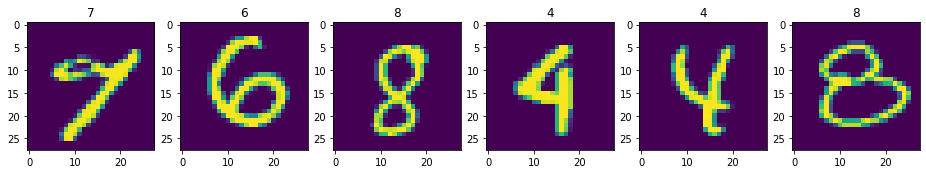

In [29]:
def display_examples(X: np.ndarray,
                     labels: np.ndarray,
                     n_images: int = 6) -> None:
    fig, axs = plt.subplots(1, n_images, figsize=(16, 5))
    idxs = random.sample(range(len(X)), n_images)

    for i, idx in enumerate(idxs):
        axs[i].imshow(X[idx, ...])
        axs[i].set_title(labels[idx])

display_examples(X, labels)

Let's binarize examples.

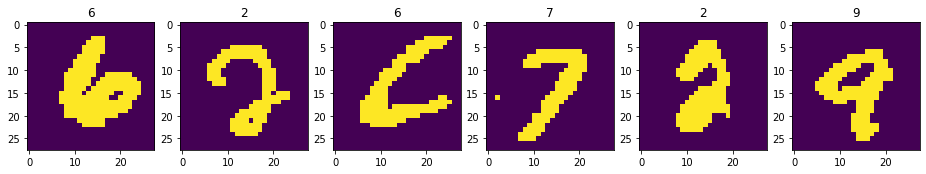

In [30]:
thresh = 40  # based on observation

X_binary = X.copy()
X_binary[X >= thresh] = 1
X_binary[X < thresh] = -1

display_examples(X_binary, labels)

Now let's add some random noise to images.

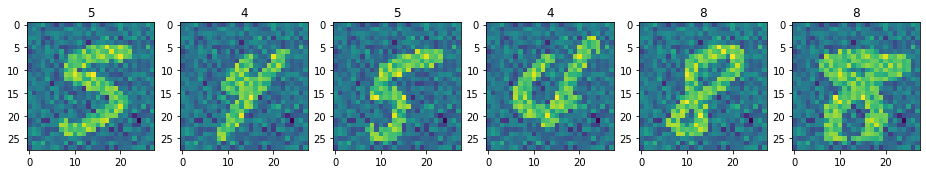

In [31]:
true_sigma = 0.5
Y = X_binary + np.random.normal(loc=0, scale=true_sigma, size=(m, m))

def display_examples(X: np.ndarray,
                     labels: np.ndarray,
                     n_images: int = 6) -> None:
    fig, axs = plt.subplots(1, n_images, figsize=(16, 5))
    idxs = random.sample(range(len(X)), n_images)

    for i, idx in enumerate(idxs):
        axs[i].imshow(X[idx, ...])
        axs[i].set_title(labels[idx])

display_examples(Y, labels)

Now we want to approximate the posterior of the original images (e.g. X) given the noisy images (e.g. Y) assuming the noise is Gaussian, as we derivated in the previous section.

Let's define the update function:

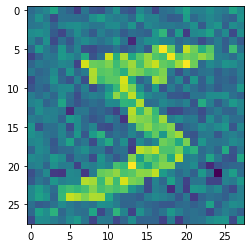

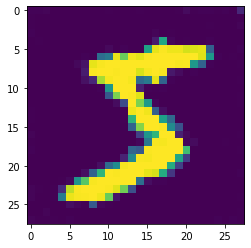

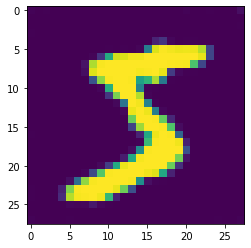

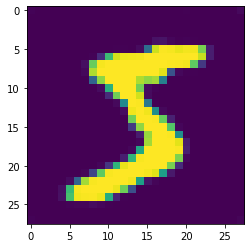

In [34]:
# Select sample
sample = Y[0].copy()
plt.imshow(sample)
plt.show()

# Initialize Normal distributions
sigma = 2
L_plus = norm(loc=1.0, scale=sigma).logpdf(sample)
L_minus = norm(loc=-1.0, scale=sigma).logpdf(sample)

# Set coupling strengths (uniform)
# Preference for same state neighbors (i.e. J > 0)
J = 1

# # Initialize mus randomly
mus = sample.copy()

# # Set optimization parameters
n_iters = 3
lambda_param = 0.5


@lru_cache(maxsize=m*m)
def neigh(y: int, x: int, height: int, width: int) -> List[Tuple[int, int]]:
    neighs = []
    diffs = [(-1, 0), (1, 0), (0, 1), (0, -1)]
    for dy, dx in diffs:
        neigh_y = y + dy
        neigh_x = x + dx
        if (0 <= y + dy < height) and (0 <= x + dx < width):
            neighs.append((neigh_y, neigh_x))
    return neighs


ms = np.zeros((m, m))
a_j = np.zeros((m, m))
for iteration in range(n_iters):
    for y in range(m):
        for x in range(m):
            neighbors = neigh(y, x, m, m)
            ms[y, x] = np.sum([J * mus[yn, xn] for yn, xn in neighbors])
            a_j[y, x] = ms[y, x] + 0.5 * (L_plus[y, x] - L_minus[y, x])
            mus[y, x] = (1 - lambda_param) * mus[y, x] + lambda_param * np.tanh(a_j[y, x])
    
    posterior = sigmoid(2*a_j)
    plt.imshow(posterior)
    plt.show()

## References

- Notes from [Princeton course](https://www.cs.princeton.edu/~bee/courses/scribe/lec_11_04_2013.pdf
)
- Towardsdatascience [post](https://towardsdatascience.com/variational-inference-ising-model-6820d3d13f6a): Variational Inference on with Ising Model
- Pages 735-739 from "Machine Learning: A Probabilistic Perspective" (Murphy, 2012)